# Calculates the NAO based on SLP

In [2]:
#load packages
import numpy as np
from netCDF4 import Dataset
import cPickle as pickle
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
%matplotlib inline
mpl.rc('font',size=10,weight='bold') #set default font size and weight for plots

In [3]:
#user defined inputs
datdir = '/Users/Karen/Dropbox/CESM/python/CESM'
var = 'PSL'
fileend = '.allyrs.nc'
month = ['12', '01', '02', '03']

#open netcdf files
varnames = dict()
for i in range(len(month)):
    fname1        = 'SURF.' + month[i] + fileend
    nc1           = Dataset(fname1)
    varnames_tmp1 = np.squeeze(nc1.variables[var][:,:,:])
    varnames[i] = np.ma.masked_greater(varnames_tmp1,1e20)
    
    lon         = nc1.variables['lon'][:]
    lat         = nc1.variables['lat'][:]

In [4]:
var_dec = varnames[0][0:varnames[0].shape[0]-1,:,:]

In [5]:
#create winter seasons (Dec-Mar)
var_nao = np.stack((varnames[0][0:varnames[0].shape[0]-1,:,:],
            varnames[1][1:varnames[0].shape[0],:,:], varnames[2][1:varnames[0].shape[0],:,:],
            varnames[3][1:varnames[0].shape[0],:,:]))

In [6]:
print varnames[0].shape
print var_nao.shape

(1101, 192, 288)
(4, 1100, 192, 288)


In [7]:
#mask missing data
var_nao = np.ma.masked_greater(var_nao,1e20)
var_dec = np.ma.masked_greater(var_dec,1e20)

In [8]:
#DJFM mean
var_nao = np.mean(var_nao,axis=0)

In [9]:
print var_nao.shape

(1100, 192, 288)


In [10]:
np.min(var_nao)

97407.398

In [11]:
#calculate anomalies
var_nao_anom = np.ma.anom(var_nao,axis=0)
var_dec_anom = np.ma.anom(var_dec,axis=0)

In [12]:
print var_nao_anom.shape

(1100, 192, 288)


In [13]:
#only latitudes 20N-90N
lat_new = lat[116:192]

In [14]:
lon[216:]

array([ 270.  ,  271.25,  272.5 ,  273.75,  275.  ,  276.25,  277.5 ,
        278.75,  280.  ,  281.25,  282.5 ,  283.75,  285.  ,  286.25,
        287.5 ,  288.75,  290.  ,  291.25,  292.5 ,  293.75,  295.  ,
        296.25,  297.5 ,  298.75,  300.  ,  301.25,  302.5 ,  303.75,
        305.  ,  306.25,  307.5 ,  308.75,  310.  ,  311.25,  312.5 ,
        313.75,  315.  ,  316.25,  317.5 ,  318.75,  320.  ,  321.25,
        322.5 ,  323.75,  325.  ,  326.25,  327.5 ,  328.75,  330.  ,
        331.25,  332.5 ,  333.75,  335.  ,  336.25,  337.5 ,  338.75,
        340.  ,  341.25,  342.5 ,  343.75,  345.  ,  346.25,  347.5 ,
        348.75,  350.  ,  351.25,  352.5 ,  353.75,  355.  ,  356.25,
        357.5 ,  358.75])

In [15]:
#only longitudes 90W-30E
lon1 = lon[0:25]
lon2 = lon[216:288]
lon_new = np.hstack((lon2,lon1))

In [16]:
var_nao_anom1 = var_nao_anom[:,116:192,0:25]
var_nao_anom2 = var_nao_anom[:,116:192,216:288]
var_nao_anom_new = np.concatenate((var_nao_anom2,var_nao_anom1),axis=2)

#var_dec_anom1 = var_dec_anom[:,:,:,0:13]
#var_dec_anom2 = var_dec_anom[:,:,:,108:144]
#var_dec_anom_new = np.concatenate((var_dec_anom2,var_dec_anom1),axis=3)

In [17]:
lon_new

array([ 270.  ,  271.25,  272.5 ,  273.75,  275.  ,  276.25,  277.5 ,
        278.75,  280.  ,  281.25,  282.5 ,  283.75,  285.  ,  286.25,
        287.5 ,  288.75,  290.  ,  291.25,  292.5 ,  293.75,  295.  ,
        296.25,  297.5 ,  298.75,  300.  ,  301.25,  302.5 ,  303.75,
        305.  ,  306.25,  307.5 ,  308.75,  310.  ,  311.25,  312.5 ,
        313.75,  315.  ,  316.25,  317.5 ,  318.75,  320.  ,  321.25,
        322.5 ,  323.75,  325.  ,  326.25,  327.5 ,  328.75,  330.  ,
        331.25,  332.5 ,  333.75,  335.  ,  336.25,  337.5 ,  338.75,
        340.  ,  341.25,  342.5 ,  343.75,  345.  ,  346.25,  347.5 ,
        348.75,  350.  ,  351.25,  352.5 ,  353.75,  355.  ,  356.25,
        357.5 ,  358.75,    0.  ,    1.25,    2.5 ,    3.75,    5.  ,
          6.25,    7.5 ,    8.75,   10.  ,   11.25,   12.5 ,   13.75,
         15.  ,   16.25,   17.5 ,   18.75,   20.  ,   21.25,   22.5 ,
         23.75,   25.  ,   26.25,   27.5 ,   28.75,   30.  ])

In [18]:
#cosine-weight
cos_tmp = np.cos((lat_new*np.pi/180.0))
cos_wgt = np.real(np.sqrt(cos_tmp))

var_nao_anom_cw = np.ma.zeros((var_nao_anom_new.shape[0],var_nao_anom_new.shape[1],var_nao_anom_new.shape[2]))
for i in range(var_nao_anom_new.shape[0]):
    for j in range(var_nao_anom_new.shape[2]):
        var_nao_anom_cw[i,:,j] = cos_wgt*var_nao_anom_new[i,:,j]
        
#var_dec_anom_cw = np.ma.zeros((var_dec_anom.shape[0],var_dec_anom.shape[1],var_dec_anom_new.shape[2],var_dec_anom_new.shape[3]))
#for i in range(var_dec_anom.shape[0]):
#    for j in range(var_dec_anom_new.shape[1]):
#        for k in range(var_dec_anom_new.shape[3]):
#            var_dec_anom_cw[i,j,:,k] = cos_wgt*var_dec_anom_new[i,j,:,k]

In [19]:
var_nao_anom_cw.shape

(1100, 76, 97)

In [20]:
# reshape the array to have one time dimension, one space dimension (Ny = latitude, Nx = longitude, Nt = time)
Nt, Ny, Nx = var_nao_anom_cw.shape
var_nao_anom_cw.shape = (Nt, Ny*Nx)

In [21]:
#perform svd analysis (note: u and v are normalized such that, e.g., u.T * u = I)
u, s, v = np.linalg.svd(var_nao_anom_cw.T, full_matrices=False)
print u.shape, v.shape, s.shape
S = np.diag(s)

# reshape spatial pattern
nao_pat = np.reshape(u, (Ny,Nx,Nt))
nao_pat.shape

(7372, 1100) (1100, 1100) (1100,)


(76, 97, 1100)

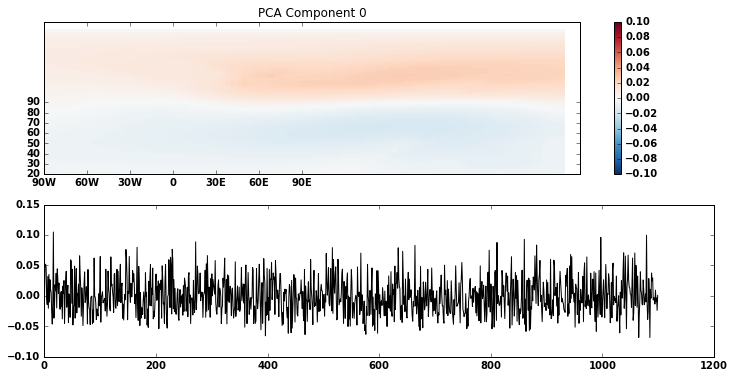

In [22]:
# look at first eof pattern and pc time series
for n in range(1):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    pc = plt.pcolormesh(nao_pat[:,:,n], cmap='RdBu_r')
    plt.title('PCA Component %g' % n)
    cbar = plt.colorbar(pc)
    plt.clim([-0.1,0.1])
    plt.yticks(np.arange(0,38,5.4),['20','30','40','50','60','70','80','90'])
    plt.xticks(np.arange(0,49,8),['90W','60W','30W','0','30E','60E','90E'])
    plt.subplot(212)
    plt.plot(np.arange(0,var_nao_anom_cw.shape[0],1), v[n,:],'k')

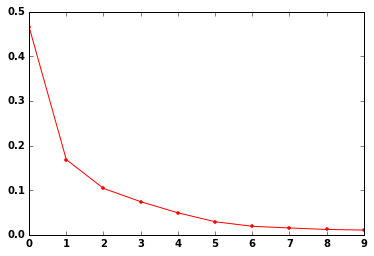

In [23]:
# variance explained by first 10 components
L = s*s.T / v.shape[1] #convert s to eigenvalues (lambda = ss.T/N)
plt.plot(L[:10] / L.sum(),'.-',color='r')

In [24]:
#re-normalize PC time series (because we are using a correlation matrix instead of a covariance matrix)
pc_ts = v * np.sqrt(Nt) #now in units of standard deviation

In [25]:
#project eof onto SLP anomaly amplitude (in hPa)
nao_pca = (u * s)/np.sqrt(Nt)
# reshape spatial pattern
nao_pat_anom = np.reshape(nao_pca, (Ny,Nx,Nt))

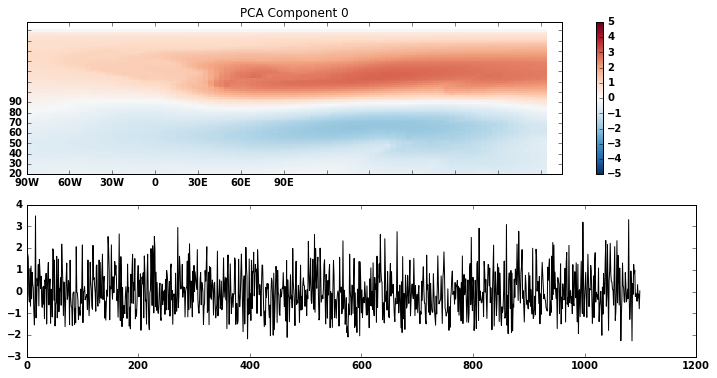

In [26]:
# look at first eof pattern and pc time series
for n in range(1):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    pc = plt.pcolormesh(nao_pat_anom[:,:,n]/100, cmap='RdBu_r') #units of hPa
    plt.title('PCA Component %g' % n)
    cbar = plt.colorbar(pc)
    plt.clim([-5,5])
    plt.yticks(np.arange(0,76,5.4),['20','30','40','50','60','70','80','90'])
    plt.xticks(np.arange(0,97,8),['90W','60W','30W','0','30E','60E','90E'])
    plt.subplot(212)
    plt.plot(np.arange(0,var_nao_anom_cw.shape[0],1), pc_ts[n,:],'k') #units of std

(array([  29.,  117.,  191.,  264.,  216.,  130.,   99.,   36.,   12.,    6.]),
 array([-2.26649703, -1.6918127 , -1.11712838, -0.54244406,  0.03224026,
         0.60692458,  1.18160891,  1.75629323,  2.33097755,  2.90566187,
         3.4803462 ]),
 <a list of 10 Patch objects>)

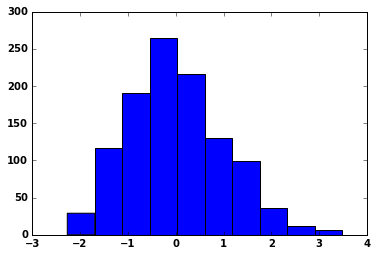

In [27]:
plt.hist(pc_ts[0,:])

In [28]:
#create daily NAO time series by regressing onto EOF pattern
Nyr, Nt, Ny, Nx = var_dec_anom_cw.shape
nao_dec_daily = np.zeros((Nyr,Nt))
tmp = np.squeeze(var_dec_anom_cw)
tmp.shape = (Nyr, Nt, Ny*Nx)
nao_dec_daily = np.dot(tmp, np.sqrt(Nyr)*u[:,0]/s[0]) #only first EOF (in units of std because we divide by s/N^(0.5))

NameError: name 'var_dec_anom_cw' is not defined

In [29]:
np.max(nao_dec_daily)

NameError: name 'nao_dec_daily' is not defined

In [30]:
#pickle DJFM NAO 
pname = 'NAO_DJFM.pickle'
with open(pname,'wb') as fp:
    pickle.dump([-pc_ts[0,:]],fp)